### Include registration modules

In [1]:
import copy

from functools import partial
from pathlib import Path
from time import time
from typing import Callable

import numpy as np
import open3d.geometry as geom
import open3d.pipelines.registration as reg
import open3d.visualization as vis
import open3d.utility as util

from result import Ok

from benthoscan.runtime import Environment, load_environment

from benthoscan.registration import PointCloud, PointCloudLoader, read_point_cloud
from benthoscan.registration import MultiTargetIndex, generate_cascade_indices
from benthoscan.registration import downsample_point_cloud, estimate_point_cloud_normals

from benthoscan.registration import (
    ExtendedRegistrationResult,
    register_point_cloud_fphp_ransac,
    register_point_cloud_icp,
    build_pose_graph,
    optimize_pose_graph,
)

from benthoscan.visualization import (
    visualize_registration,
    visualize_registration_batch,
)

# from benthoscan.tasks.registration import RegistrationTaskConfig

from benthoscan.utils.log import logger

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load environment and configure data loaders

In [2]:
environment: Environment = load_environment()

DATA_DIR: Path = Path("/home/martin/dev/benthoscan/.cache")

point_cloud_files: dict = {
    0: DATA_DIR / Path("qdc5ghs3_20100430_024508.ply"),
    1: DATA_DIR / Path("qdc5ghs3_20120501_033336.ply"),
    2: DATA_DIR / Path("qdc5ghs3_20130405_103429.ply"),
    3: DATA_DIR / Path("qdc5ghs3_20210315_230947.ply"),
}

loaders: dict = {
    key: partial(read_point_cloud, path=path) for key, path in point_cloud_files.items()
}

count = len(loaders)
if count < 2:
    logger.error(f"invalid number of point clouds for registration: {count}")

### Configure preprocessor and registrator

In [3]:
def downsample_and_estimate_normals(cloud: PointCloud, voxel_size: float) -> PointCloud:
    """Preprocesses a point cloud by downsampling and estimating the normals."""
    downsampled: PointCloud = downsample_point_cloud(cloud, spacing=voxel_size)
    preprocessed: PointCloud = estimate_point_cloud_normals(downsampled)
    return preprocessed


def registration_worker(
    source_loader: PointCloudLoader,
    target_loader: PointCloudLoader,
    preprocessor: Callable[[PointCloud], PointCloud],
    registrator: Callable[[PointCloud, PointCloud], ExtendedRegistrationResult],
) -> ExtendedRegistrationResult:
    """Worker function that performs the point cloud registration."""

    source_cloud: PointCloud = source_loader().unwrap()
    target_cloud: PointCloud = target_loader().unwrap()

    preprocessed_source: PointCloud = preprocessor(source_cloud)
    preprocessed_target: PointCloud = preprocessor(target_cloud)

    result: ExtendedRegistratorResult = registrator(
        source=preprocessed_source, target=preprocessed_target
    )

    return result

### Transformation Helpers

In [48]:
from scipy.spatial.transform import Rotation


def decompose_transformation(transformation: np.ndarray) -> tuple:
    """Decomposes a 3D rigid body transformation into scale, rotation, and translation."""

    assert transformation.shape == (
        4,
        4,
    ), "transformation is not a 3D rigid-body transformation"

    scaled_rotation: np.ndarray = transformation[:3, :3]
    translation: np.ndarray = transformation[:3, 3]

    scale: float = np.linalg.norm(scaled_rotation, axis=1)[0]
    rotation: np.ndarray = scaled_rotation / scale

    return scale, rotation, translation


def decompose_rotation(rotation: np.ndarray) -> tuple:
    """Decomposes a 3D rotation matrix into yaw, roll, and pitch angles."""

    assert rotation.shape == (
        3,
        3,
    ), "rotation is not a 3D rotation matrix"

    rotation: Rotation = Rotation.from_matrix(rotation)

    yaw, roll, pitch = rotation.as_euler("ZYX", degrees=True)

    return yaw, roll, pitch


def log_registration(
    source: int, target: int, result: ExtendedRegistrationResult
) -> None:
    """TODO"""

    scale, rotation, translation = decompose_transformation(result.transformation)

    logger.info("")
    logger.info(f"Source:       {source}")
    logger.info(f"Target:       {target}")
    logger.info(f"Corresp.:     {len(result.correspondence_set)}")
    logger.info(f"Fitness:      {result.fitness}")
    logger.info(f"Inlier RMSE:  {result.inlier_rmse}")
    logger.info(f"Trans. scale:    {scale}")
    logger.info(f"Trans. trans.:   {translation}")
    logger.info(f"Trans. rot.:     {rotation}")
    logger.info("")

In [7]:
# NOTE: Parameters - move to config
VOXEL_SIZE: float = 0.20

# FPFH feature parameters
FEATURE_RADIUS: float = 2.00  # NOTE: 2.00
FEATURE_NEIGHBOURS: int = 500

# Validation and estimation
CORRESPONDENCE_DISTANCE: float = 0.20
EDGE_LENGTH: float = 0.95  # NOTE: 0.95
NORMAL_ANGLE: float = 5.0

MUTUAL_FILTER: bool = True
ESTIMATE_SCALE: bool = True

# RANSAC parameters
SAMPLE_COUNT: int = 3
MAX_ITERATIONS: int = 1000000
CONFIDENCE: float = 1.0  # NOTE: 0.999


preprocessor: Callable[[PointCloud], PointCloud] = partial(
    downsample_and_estimate_normals, voxel_size=VOXEL_SIZE
)

registrator = partial(
    register_point_cloud_fphp_ransac,
    distance_threshold=CORRESPONDENCE_DISTANCE,
    feature_radius=FEATURE_RADIUS,
    feature_neighbours=FEATURE_NEIGHBOURS,
    max_iterations=MAX_ITERATIONS,
    mutual_filter=MUTUAL_FILTER,
    confidence=CONFIDENCE,
    sample_count=SAMPLE_COUNT,
    edge_check=EDGE_LENGTH,
    normal_check=NORMAL_ANGLE,
    scaling=ESTIMATE_SCALE,
)

### Test registrator parameters on a single case

In [8]:
# Select some point clouds to tune the registration - 0-3 is the really hard case, but 1-3 and 2-3 are also challenging
test_source: int = 0
test_target: int = 3

test_results: list[ExtendedRegistrationResult] = list()

with util.VerbosityContextManager(util.VerbosityLevel.Debug) as cm:

    source_cloud: PointCloud = loaders[test_source]().unwrap()
    target_cloud: PointCloud = loaders[test_target]().unwrap()

    for i in range(10):

        start: float = time()

        result: ExtendedRegistrationResult = registration_worker(
            source_loader=lambda: Ok(source_cloud),
            target_loader=lambda: Ok(target_cloud),
            preprocessor=preprocessor,
            registrator=registrator,
        )

        end: float = time()

        logger.info(f"Ransac time: {end - start}")

        log_registration(0, 3, result)

        test_results.append(result)

[Open3D DEBUG] Format auto File /home/martin/dev/benthoscan/.cache/qdc5ghs3_20100430_024508.ply
[Open3D DEBUG] Read geometry::PointCloud: 10457378 vertices.
[Open3D DEBUG] Format auto File /home/martin/dev/benthoscan/.cache/qdc5ghs3_20210315_230947.ply
[Open3D DEBUG] Read geometry::PointCloud: 15048357 vertices.
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 880154: registration fitness=0.449, corres inlier ratio=0.005, Est. max k = inf
[Open3D DEBUG] Thread 634485: registration fitness=0.102, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 393383: registration fitness=0.356, corres inlier ratio=0.008, Est. max k = inf
[Open3D DEBUG] Thread 520682: registration fitness=0.328, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 267717: registration fitness=0.078, cor

2024-07-07 09:34:10.591 | INFO     | __main__:<module>:25 - Ransac time: 9.008347988128662
2024-07-07 09:34:10.593 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:34:10.595 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:34:10.597 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:34:10.598 | INFO     | __main__:log_registration:28 - Corresp.:     13191
2024-07-07 09:34:10.598 | INFO     | __main__:log_registration:29 - Fitness:      0.44946844759438465
2024-07-07 09:34:10.599 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.10900223583854193
2024-07-07 09:34:10.601 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9662130097286925
2024-07-07 09:34:10.603 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.39281453 12.00388305 -1.5436856 ]
2024-07-07 09:34:10.603 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.9991119  -0.04171887  0.00591174]
 [ 0.04168451  0.99911387  0.

[Open3D DEBUG] Thread 730087: registration fitness=0.340, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] RANSAC exits after 63 validations. Best inlier ratio 4.494684e-01, RMSE 1.090022e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 502698: registration fitness=0.088, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 385954: registration fitness=0.282, corres inlier ratio=0.007, Est. max k = inf
[Open3D DEBUG] Thread 254936: registration fitness=0.076, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 886495: registration fitness=0.291, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 020782: registration fitness=0.073, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 522987: registration fitness=0.221, corres inlier

2024-07-07 09:34:26.388 | INFO     | __main__:<module>:25 - Ransac time: 15.782273054122925
2024-07-07 09:34:26.389 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:34:26.391 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:34:26.391 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:34:26.393 | INFO     | __main__:log_registration:28 - Corresp.:     12991
2024-07-07 09:34:26.395 | INFO     | __main__:log_registration:29 - Fitness:      0.4426536731634183
2024-07-07 09:34:26.396 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.10978516636098082
2024-07-07 09:34:26.397 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9716023723904313
2024-07-07 09:34:26.398 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.26597472 11.72096777 -1.35439407]
2024-07-07 09:34:26.400 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.99838536 -0.05659721  0.00484126]
 [ 0.05660698  0.99839472 -0.

[Open3D DEBUG] Thread 366463: registration fitness=0.210, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 248574: registration fitness=0.122, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] RANSAC exits after 50 validations. Best inlier ratio 4.426537e-01, RMSE 1.097852e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 628713: registration fitness=0.195, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 630353: registration fitness=0.271, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 258871: registration fitness=0.256, corres inlier ratio=0.002, Est. max k = inf
[Open3D DEBUG] Thread 129390: registration fitness=0.098, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 759247: registration fitness=0.108, corres inlier

2024-07-07 09:34:41.739 | INFO     | __main__:<module>:25 - Ransac time: 15.337153673171997
2024-07-07 09:34:41.740 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:34:41.741 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:34:41.742 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:34:41.742 | INFO     | __main__:log_registration:28 - Corresp.:     13252
2024-07-07 09:34:41.743 | INFO     | __main__:log_registration:29 - Fitness:      0.4515469537958294
2024-07-07 09:34:41.743 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.10165770634202528
2024-07-07 09:34:41.744 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9648816789358121
2024-07-07 09:34:41.745 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 6.88139216 11.93976592 -1.61025148]
2024-07-07 09:34:41.746 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 9.99070759e-01 -4.28684497e-02 -4.46250662e-03]
 [ 4.28665731e-02

[Open3D DEBUG] RANSAC exits after 59 validations. Best inlier ratio 4.515470e-01, RMSE 1.016577e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 008637: registration fitness=0.330, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 512154: registration fitness=0.149, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 136352: registration fitness=0.382, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 776636: registration fitness=0.276, corres inlier ratio=0.004, Est. max k = inf
[Open3D DEBUG] Thread 650793: registration fitness=0.317, corres inlier ratio=0.002, Est. max k = inf
[Open3D DEBUG] Thread 897205: registration fitness=0.047, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 533616: registration fitness=0.354, corres inlier

2024-07-07 09:34:53.702 | INFO     | __main__:<module>:25 - Ransac time: 11.955401420593262
2024-07-07 09:34:53.704 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:34:53.707 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:34:53.708 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:34:53.709 | INFO     | __main__:log_registration:28 - Corresp.:     12503
2024-07-07 09:34:53.710 | INFO     | __main__:log_registration:29 - Fitness:      0.4260256235518604
2024-07-07 09:34:53.711 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.11247633973034224
2024-07-07 09:34:53.712 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9959052046300727
2024-07-07 09:34:53.714 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 1.1932704  -0.68629977  0.2313325 ]
2024-07-07 09:34:53.715 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.97055623 -0.23945309 -0.02613073]
 [ 0.23947356  0.97089995 -0.

[Open3D DEBUG] RANSAC exits after 50 validations. Best inlier ratio 4.260256e-01, RMSE 1.124763e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 251186: registration fitness=0.359, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 131054: registration fitness=0.398, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 754443: registration fitness=0.339, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 388333: registration fitness=0.150, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 634876: registration fitness=0.065, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 880771: registration fitness=0.225, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 520163: registration fitness=0.104, corres inlier

2024-07-07 09:35:09.695 | INFO     | __main__:<module>:25 - Ransac time: 15.9770987033844
2024-07-07 09:35:09.696 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:35:09.696 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:35:09.697 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:35:09.697 | INFO     | __main__:log_registration:28 - Corresp.:     12704
2024-07-07 09:35:09.698 | INFO     | __main__:log_registration:29 - Fitness:      0.4328744718549816
2024-07-07 09:35:09.698 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.11417457126149487
2024-07-07 09:35:09.699 | INFO     | __main__:log_registration:31 - Trans. scale:    1.0179594333935251
2024-07-07 09:35:09.700 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.25595585 11.34245539  0.79999549]
2024-07-07 09:35:09.701 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 9.99425733e-01 -3.38690755e-02  1.04397723e-03]
 [ 3.38777365e-02  

[Open3D DEBUG] RANSAC exits after 57 validations. Best inlier ratio 4.328745e-01, RMSE 1.141746e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 254586: registration fitness=0.244, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 129442: registration fitness=0.168, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 880881: registration fitness=0.039, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 507483: registration fitness=0.096, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 507557: registration fitness=0.205, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 006046: registration fitness=0.091, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 659145: registration fitness=0.388, corres inlier

2024-07-07 09:35:25.032 | INFO     | __main__:<module>:25 - Ransac time: 15.329293251037598
2024-07-07 09:35:25.033 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:35:25.037 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:35:25.037 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:35:25.041 | INFO     | __main__:log_registration:28 - Corresp.:     13126
2024-07-07 09:35:25.042 | INFO     | __main__:log_registration:29 - Fitness:      0.44725364590432054
2024-07-07 09:35:25.044 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.09880716968346334
2024-07-07 09:35:25.046 | INFO     | __main__:log_registration:31 - Trans. scale:    1.008682565019682
2024-07-07 09:35:25.049 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.0083251  11.72336023  0.41235003]
2024-07-07 09:35:25.050 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.9995358  -0.03028414 -0.00332609]
 [ 0.03027639  0.99953879 -0.

[Open3D DEBUG] RANSAC exits after 56 validations. Best inlier ratio 4.472536e-01, RMSE 9.880717e-02
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 255742: registration fitness=0.175, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 752276: registration fitness=0.044, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 637692: registration fitness=0.383, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 383442: registration fitness=0.162, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 015714: registration fitness=0.167, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 893325: registration fitness=0.131, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 515796: registration fitness=0.061, corres inlier

2024-07-07 09:35:38.510 | INFO     | __main__:<module>:25 - Ransac time: 13.45688796043396
2024-07-07 09:35:38.511 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:35:38.512 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:35:38.512 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:35:38.513 | INFO     | __main__:log_registration:28 - Corresp.:     12409
2024-07-07 09:35:38.513 | INFO     | __main__:log_registration:29 - Fitness:      0.42282267956930625
2024-07-07 09:35:38.514 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.11210157893520868
2024-07-07 09:35:38.515 | INFO     | __main__:log_registration:31 - Trans. scale:    1.0407933003882737
2024-07-07 09:35:38.515 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.07672396 11.46205192  1.87567275]
2024-07-07 09:35:38.516 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 9.99966280e-01 -8.18352797e-03 -6.85028371e-04]
 [ 8.17944126e-03

[Open3D DEBUG] RANSAC exits after 56 validations. Best inlier ratio 4.228227e-01, RMSE 1.121016e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 877680: registration fitness=0.344, corres inlier ratio=0.002, Est. max k = inf
[Open3D DEBUG] Thread 501320: registration fitness=0.034, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 252596: registration fitness=0.056, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 506969: registration fitness=0.042, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 020752: registration fitness=0.190, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 153108: registration fitness=0.328, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 406704: registration fitness=0.134, corres inlier

2024-07-07 09:35:52.758 | INFO     | __main__:<module>:25 - Ransac time: 14.240346670150757
2024-07-07 09:35:52.772 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:35:52.778 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:35:52.779 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:35:52.781 | INFO     | __main__:log_registration:28 - Corresp.:     13179
2024-07-07 09:35:52.782 | INFO     | __main__:log_registration:29 - Fitness:      0.44905956112852663
2024-07-07 09:35:52.783 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.1071897293802055
2024-07-07 09:35:52.783 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9900603312358718
2024-07-07 09:35:52.784 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.35497566 11.95898797 -0.43082158]
2024-07-07 09:35:52.785 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.99907909 -0.04265684  0.0046227 ]
 [ 0.04262778  0.99907171  0.

[Open3D DEBUG] Thread 620837: registration fitness=0.227, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] RANSAC exits after 59 validations. Best inlier ratio 4.490596e-01, RMSE 1.071897e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 500131: registration fitness=0.416, corres inlier ratio=0.004, Est. max k = inf
[Open3D DEBUG] Thread 877875: registration fitness=0.145, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 751079: registration fitness=0.310, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 006856: registration fitness=0.171, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 381962: registration fitness=0.087, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 634016: registration fitness=0.212, corres inlier

2024-07-07 09:36:09.225 | INFO     | __main__:<module>:25 - Ransac time: 16.43881058692932
2024-07-07 09:36:09.227 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:36:09.230 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:36:09.231 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:36:09.232 | INFO     | __main__:log_registration:28 - Corresp.:     13215
2024-07-07 09:36:09.233 | INFO     | __main__:log_registration:29 - Fitness:      0.45028622052610057
2024-07-07 09:36:09.234 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.107702666523245
2024-07-07 09:36:09.234 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9678649229159291
2024-07-07 09:36:09.236 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 5.32067238 -1.10442976 -0.91399827]
2024-07-07 09:36:09.238 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.24125605 -0.97044992 -0.00473954]
 [ 0.97042185  0.24119918  0.01

[Open3D DEBUG] RANSAC exits after 61 validations. Best inlier ratio 4.502862e-01, RMSE 1.077027e-01
[Open3D DEBUG] Pointcloud down sampled from 10457378 points to 29348 points.
[Open3D DEBUG] Pointcloud down sampled from 15048357 points to 37926 points.
[Open3D DEBUG] 5288 correspondences remain after mutual filter
[Open3D DEBUG] Thread 130062: registration fitness=0.340, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 878023: registration fitness=0.033, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 255553: registration fitness=0.106, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 637990: registration fitness=0.206, corres inlier ratio=0.001, Est. max k = inf
[Open3D DEBUG] Thread 389161: registration fitness=0.316, corres inlier ratio=0.002, Est. max k = inf
[Open3D DEBUG] Thread 878367: registration fitness=0.198, corres inlier ratio=0.000, Est. max k = inf
[Open3D DEBUG] Thread 520185: registration fitness=0.107, corres inlier

2024-07-07 09:36:24.014 | INFO     | __main__:<module>:25 - Ransac time: 14.774672508239746
2024-07-07 09:36:24.016 | INFO     | __main__:log_registration:25 - 
2024-07-07 09:36:24.019 | INFO     | __main__:log_registration:26 - Source:       0
2024-07-07 09:36:24.020 | INFO     | __main__:log_registration:27 - Target:       3
2024-07-07 09:36:24.022 | INFO     | __main__:log_registration:28 - Corresp.:     13064
2024-07-07 09:36:24.024 | INFO     | __main__:log_registration:29 - Fitness:      0.445141065830721
2024-07-07 09:36:24.037 | INFO     | __main__:log_registration:30 - Inlier RMSE:  0.10856145995363148
2024-07-07 09:36:24.038 | INFO     | __main__:log_registration:31 - Trans. scale:    0.9852721385619367
2024-07-07 09:36:24.040 | INFO     | __main__:log_registration:32 - Trans. trans.:   [ 7.14261493 11.42255907 -0.67093758]
2024-07-07 09:36:24.041 | INFO     | __main__:log_registration:33 - Trans. rot.:     [[ 0.99968535 -0.02494768 -0.00260927]
 [ 0.02493806  0.99968232 -0.0

[Open3D DEBUG] RANSAC exits after 48 validations. Best inlier ratio 4.451411e-01, RMSE 1.085615e-01


### Define registration plotting functions

In [147]:
import plotly.express as px
import plotly.graph_objects as go

from plotly.tools import make_subplots

# TODO: Implement plotting of registration results


def create_registration_figure() -> go.Figure:
    """TODO"""

    figure: go.Figure = make_subplots(
        rows=2,
        cols=3,
        column_widths=[1, 1, 1],
        row_heights=[1, 1],
        subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4", "Plot 5", "Plot 6"),
    )

    return figure


def create_registration_traces(
    result: ExtendedRegistrationResult,
    name: str,
    legendgroup: int,
    color: str = "blue",
) -> dict:
    """Creates graph objects for a registration result. The fitness, error, and correspondence count
    is plotted in addition to the transformation components"""

    scale, rotation, translation = decompose_transformation(result.transformation)
    yaw, roll, pitch = decompose_rotation(rotation)

    traces: dict = dict()

    traces["fitness"] = go.Bar(
        name=name,
        x=["Fitness"],
        y=[result.fitness],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=True,
    )

    traces["rmse"] = go.Bar(
        name=name,
        x=["RMSE"],
        y=[result.inlier_rmse],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=False,
    )

    traces["correspondences"] = go.Bar(
        name=name,
        x=["Correspondences"],
        y=[len(result.correspondence_set)],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=False,
    )

    traces["scale"] = go.Bar(
        name=name,
        x=["Scale"],
        y=[scale],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=False,
    )

    traces["rotation"] = go.Bar(
        name=name,
        x=["Rotz", "Roty", "Rotx"],
        y=[yaw, pitch, roll],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=False,
    )

    traces["translation"] = go.Bar(
        name=name,
        x=["Trans-x", "Trans-y", "Trans-z"],
        y=[translation[0], translation[1], translation[2]],
        marker_color=color,
        hoverinfo="x+y",
        legendgroup=legendgroup,
        showlegend=False,
    )

    return traces

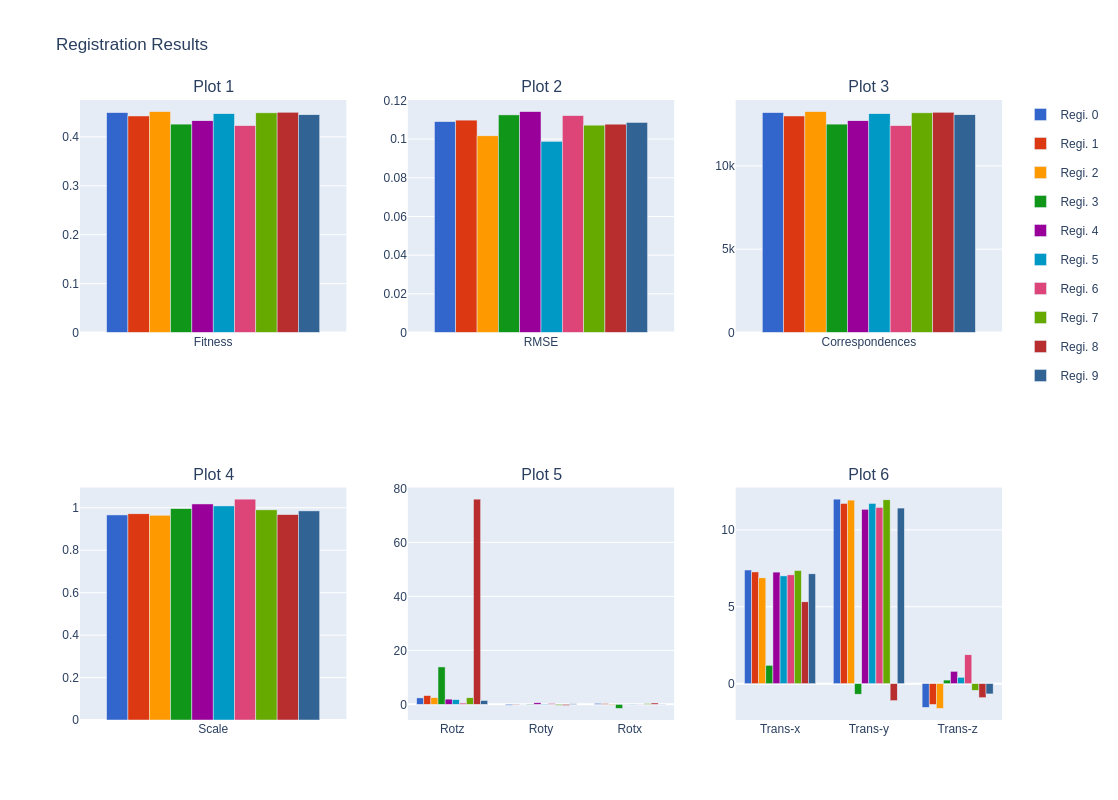

In [149]:
figure: go.Figure = create_registration_figure()

# colors: list[str] = px.colors.sequential.Plasma_r
colors: list[str] = px.colors.qualitative.G10


for index, (result, color) in enumerate(zip(test_results, colors)):

    traces: dict = create_registration_traces(
        result,
        name=f"Regi. {index}",
        legendgroup=index,
        color=color,
    )

    figure.add_trace(traces["fitness"], row=1, col=1)
    figure.add_trace(traces["rmse"], row=1, col=2)
    figure.add_trace(traces["correspondences"], row=1, col=3)

    figure.add_trace(traces["scale"], row=2, col=1)
    figure.add_trace(traces["rotation"], row=2, col=2)
    figure.add_trace(traces["translation"], row=2, col=3)


figure.update_layout(height=800, width=1000, title_text="Registration Results")
figure.show()

visualize_test: bool = False

if visualize_test:
    for index, result in enumerate(test_results):
        visualize_registration(
            source=source_cloud,
            target=target_cloud,
            transformation=result.transformation,
            title=f"Test case: {test_source}, {test_target}, {index}",
        )

### Generate indices and perform registration

In [ ]:
indices: list[MultiTargetIndex] = generate_cascade_indices(len(loaders))

result_storage = {
    "feature_matching": dict(),
    "incremental_coarse": dict(),
}

In [ ]:
for index in indices:
    source = index.source

    results: dict[int, ExtendedRegistrationResult] = dict()

    for target in index.targets:

        result: ExtendedRegistrationResult = registration_worker(
            source_loader=loaders[source],
            target_loader=loaders[target],
            preprocessor=preprocessor,
            registrator=registrator,
        )

        log_registration(source, target, result)

        results[target] = result

    result_storage["feature_matching"][source] = results

### Draw registration and plot results
- TODO: Draw registered point clouds
- TODO: Plot point clouds, correspondences, and error distribution

In [ ]:
visualize_registration_batch(
    storage=result_storage["feature_matching"],
    loaders=loaders,
)

### Perform coarse incremental registration

In [ ]:
icp_coarse_parameters = dict()
icp_coarse_parameters["voxel"] = 0.05
icp_coarse_parameters["distance"] = 0.075

loss = reg.TukeyLoss(k=0.20)
icp_coarse_parameters["estimator"] = reg.TransformationEstimationPointToPlane(loss)

icp_preprocessor: Callable[[PointCloud], PointCloud] = partial(
    downsample_point_cloud,
    spacing=icp_coarse_parameters["voxel"],
)

icp_registrator = partial(
    register_point_cloud_icp,
    distance_threshold=icp_coarse_parameters["distance"],
    distance_measure=icp_coarse_parameters["estimator"],
)

In [ ]:
result_storage["incremental_coarse"] = dict()


for index in indices:
    source = index.source

    results: dict[int, ExtendedRegistrationResult] = dict()

    for target in index.targets:

        transformation: np.ndarray = result_storage["feature_matching"][source][
            target
        ].transformation

        source_cloud: PointCloud = loaders[source]().unwrap()
        target_cloud: PointCloud = loaders[target]().unwrap()

        source_prepped: PointCloud = icp_preprocessor(source_cloud)
        target_prepped: PointCloud = icp_preprocessor(target_cloud)

        result: ExtendedRegistrationResult = icp_registrator(
            source=source_prepped, target=target_prepped, transformation=transformation
        )

        logger.info("")
        logger.info(f"Source {source}, target {target}")
        logger.info(f"Initial transformation: {transformation}")
        logger.info(f"Refined transformation: {result.transformation}")
        logger.info("")

        results[target] = result

    result_storage["incremental_coarse"][source] = results

In [ ]:
visualize_registration_batch(
    storage=result_storage["incremental_coarse"],
    loaders=loaders,
    source_color=[0.60, 0.20, 0.20],
    target_color=[0.20, 0.20, 0.60],
)

### TODO: Perform fine / colored registration

In [ ]:
# TODO: Add colored ICP

### TODO: Perform multiway registration

In [ ]:
initial_graph: reg.PoseGraph = build_pose_graph(result_storage["incremental_coarse"])

with util.VerbosityContextManager(util.VerbosityLevel.Debug) as cm:
    optimized_graph: reg.PoseGraph = optimize_pose_graph(
        initial_graph,
        correspondence_distance=0.075,
        prune_threshold=0.25,
        preference_loop_closure=100.0,
        reference_node=0,
    )

for identifier in result_storage["incremental_coarse"]:
    logger.info(optimized_graph.nodes[identifier].pose)

### Draw final registration results

In [ ]:
transformed_clouds: list[PointCloud] = list()

for identifier in result_storage["incremental_coarse"]:

    cloud: PointCloud = loaders[identifier]().unwrap()
    cloud.transform(optimized_graph.nodes[identifier].pose)
    transformed_clouds.append(cloud)

vis.draw_geometries(transformed_clouds)